<a href="https://colab.research.google.com/github/boymanalu/eOfficeDisbudpar/blob/master/m300W2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nb_path = '/content/drive/My Drive/apython/'
# DATASET
DATASET_COLUMNS = ["no","comments", "ratings"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 5
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIF"
NEGATIVE = "NEGATIF"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

Using TensorFlow backend.


In [ ]:
df = pd.read_excel(nb_path+"dataset_best.xlsx")
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 210044
TEST size: 52511


In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load(nb_path+"Model_W2V_300.model")

2020-06-25 03:59:29,967 : INFO : loading Word2Vec object from /content/drive/My Drive/apython/Model_W2V_300.model
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-06-25 03:59:31,939 : INFO : loading wv recursively from /content/drive/My Drive/apython/Model_W2V_300.model.wv.* with mmap=None
2020-06-25 03:59:31,940 : INFO : setting ignored attribute vectors_norm to None
2020-06-25 03:59:31,942 : INFO : loading vocabulary recursively from /content/drive/My Drive/apython/Model_W2V_300.model.vocabulary.* with mmap=None
2020-06-25 03:59:31,956 : INFO : loading trainables recursively from /content/drive/My Drive/apython/Model_W2V_300.model.trainables.* with mmap=None
2020-06-25 03:59:31,9

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.comments)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 59761
CPU times: user 2.57 s, sys: 13.1 ms, total: 2.58 s
Wall time: 2.58 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.comments), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.comments), maxlen=SEQUENCE_LENGTH)

CPU times: user 4.11 s, sys: 91.3 ms, total: 4.21 s
Wall time: 4.21 s


In [ ]:
labels = df_train.ratings.unique().tolist()
labels

['POSITIF', 'NEGATIF']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.ratings.tolist())

y_train = encoder.transform(df_train.ratings.tolist())
y_test = encoder.transform(df_test.ratings.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (210044, 300)
y_train (210044, 1)

x_test (52511, 300)
y_test (52511, 1)


In [ ]:
embedding_matrix = np.zeros((10000, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(59761, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          17928300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 18,088,801
Trainable params: 160,501
Non-trainable params: 17,928,300
_________________________________________________________________


In [ ]:
import keras
opt = keras.optimizers.Adam()
model.compile(loss='mse',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=100,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 189039 samples, validate on 21005 samples
Epoch 1/100
189039/189039 [==============================] - 154s 813us/step - loss: 0.1248 - accuracy: 0.8317 - val_loss: 0.1115 - val_accuracy: 0.8503
Epoch 2/100
189039/189039 [==============================] - 149s 789us/step - loss: 0.1126 - accuracy: 0.8489 - val_loss: 0.1086 - val_accuracy: 0.8547
Epoch 3/100
189039/189039 [==============================] - 150s 792us/step - loss: 0.1102 - accuracy: 0.8526 - val_loss: 0.1075 - val_accuracy: 0.8574
Epoch 4/100
189039/189039 [==============================] - 149s 788us/step - loss: 0.1086 - accuracy: 0.8551 - val_loss: 0.1066 - val_accuracy: 0.8592
Epoch 5/100
189039/189039 [==============================] - 150s 791us/step - loss: 0.1075 - accuracy: 0.8566 - val_loss: 0.1053 - val_accuracy: 0.8598
Epoch 6/100
189039/189039 [==============================] - 151s 799us/step - loss: 0.1063 - accuracy: 0.8580 - val_loss: 0.1046 - val_accuracy: 0.8614
Epoch 7/100
189039/189039 [====

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

52511/52511 [==============================] - 10s 191us/step

ACCURACY: 0.8665803074836731
LOSS: 0.10133711823728955
CPU times: user 6.29 s, sys: 2.48 s, total: 8.77 s
Wall time: 10.1 s


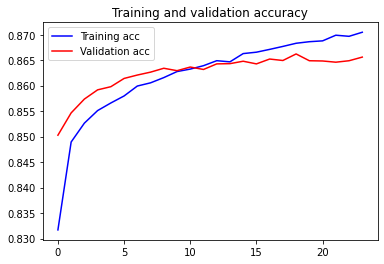

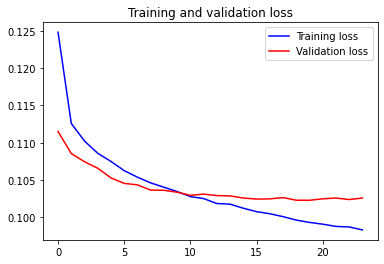

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        #label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.ratings)
scores = model.predict(x_test, verbose=1, batch_size=BATCH_SIZE)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

52511/52511 [==============================] - 10s 192us/step
CPU times: user 7.21 s, sys: 3.03 s, total: 10.2 s
Wall time: 10.3 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

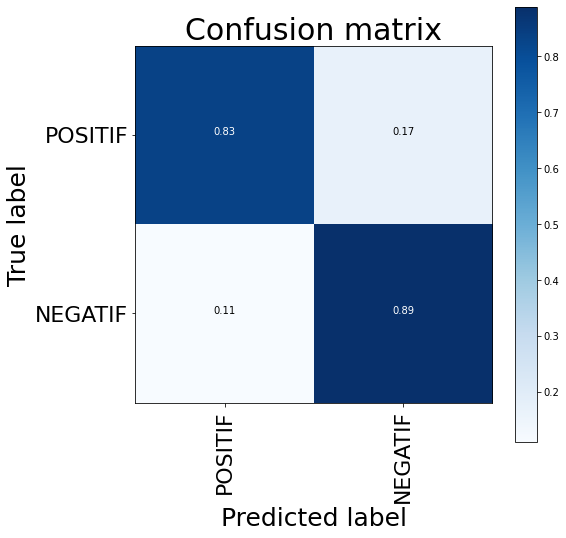

CPU times: user 371 ms, sys: 6.48 ms, total: 377 ms
Wall time: 387 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=df_train.ratings.unique(), title="Confusion matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_1d, y_pred_1d))
print(classification_report(y_test_1d, y_pred_1d))

[[17799  3540]
 [ 3466 27706]]
              precision    recall  f1-score   support

     NEGATIF       0.84      0.83      0.84     21339
     POSITIF       0.89      0.89      0.89     31172

    accuracy                           0.87     52511
   macro avg       0.86      0.86      0.86     52511
weighted avg       0.87      0.87      0.87     52511



In [ ]:
hasil_akurasi = pd.DataFrame(list(zip(acc,loss,val_acc,val_loss)), 
               columns =['Akurasi', 'Error','Val Akurasi','Val Loss']) 
hasil_akurasi.to_excel(nb_path+"hasil_2.xlsx")